Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
74779,25/03/2016 20:40,4200,sedan,2003,manual,102,passat,125000,7,petrol,volkswagen,no,25/03/2016 00:00,0,92637,03/04/2016 01:25
262059,12/03/2016 21:54,900,small,1999,manual,50,arosa,125000,2,petrol,seat,yes,12/03/2016 00:00,0,40789,20/03/2016 03:48
211714,11/03/2016 09:50,4201,sedan,1989,NaN,160,other,150000,6,petrol,mercedes_benz,no,11/03/2016 00:00,0,97857,16/03/2016 17:20
191422,15/03/2016 20:45,3399,small,2007,manual,86,ibiza,150000,1,petrol,seat,no,15/03/2016 00:00,0,47803,20/03/2016 19:15
234618,08/03/2016 17:50,9199,wagon,2007,auto,150,3er,150000,8,petrol,bmw,no,08/03/2016 00:00,0,29525,07/04/2016 08:45
252404,08/03/2016 02:36,3950,coupe,2009,manual,109,c4,100000,5,petrol,citroen,no,08/03/2016 00:00,0,45879,10/03/2016 18:45
147147,25/03/2016 20:38,650,wagon,1995,manual,0,passat,150000,2,petrol,volkswagen,no,25/03/2016 00:00,0,48249,28/03/2016 21:19
23814,11/03/2016 11:49,180,small,1999,manual,65,corsa,150000,0,petrol,opel,yes,11/03/2016 00:00,0,86865,07/04/2016 03:46
197128,27/03/2016 23:56,5500,small,2012,manual,0,twingo,50000,7,petrol,renault,no,27/03/2016 00:00,0,44652,06/04/2016 09:15
111746,22/03/2016 19:48,599,small,1999,manual,39,seicento,150000,4,petrol,fiat,no,22/03/2016 00:00,0,32052,24/03/2016 04:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

The dtypes and basic information looks mostly good aside from the indication of some missing values. Based on the goal of the project, no dtypes need to be changed. I'll then start looking deeper into the missing values and possible duplicates. I will also remove unnecessary features to avoid overfitting.

In [5]:
# removing extra non-essential features
# df = df.drop(columns=['LastSeen', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures', 'VehicleType', 'Brand']) 
columns_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode', 
                   'NumberOfPictures', 'VehicleType', 'Brand']

df = df.drop(columns=columns_to_drop)

In [6]:
df.duplicated().sum()

54196

In [7]:
# dropping the duplicates since there is not a massive amount and it is unlikely that it will damage the integrity of the data
df = df.drop_duplicates().reset_index(drop=True)  

In [8]:
# verifying changes 
df.duplicated().sum()

0

In [9]:
df.isna().sum()

Price                   0
RegistrationYear        0
Gearbox             16471
Power                   0
Model               17316
Mileage                 0
FuelType            29977
NotRepaired         62820
dtype: int64

There's a great amount of missing values in a good amount of features. Since they contribute to a decent percentage of the data, I will opt not to remove them but instead to fill them with 'missing'. This then indicates that the value is not available while also maintaining the most amount of data integrity possible. 

In [10]:
# imputing missing values with 'missing'
categorical_cols = ['Gearbox', 'Model', 'FuelType', 'NotRepaired']
df[categorical_cols] = df[categorical_cols].fillna('missing') 

In [11]:
# verifying changes
df.duplicated().sum()

0

In [12]:
df.describe()

,Price,RegistrationYear,Power,Mileage
count,300173.000000,300173.000000,300173.000000,300173.000000
mean,4531.414098,2004.387377,111.437061,126821.133147
std,4584.184663,90.432629,203.732378,38707.352570
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Based on the minimum and maximum values shown for a majority of these features, there are definitely some outliers. 

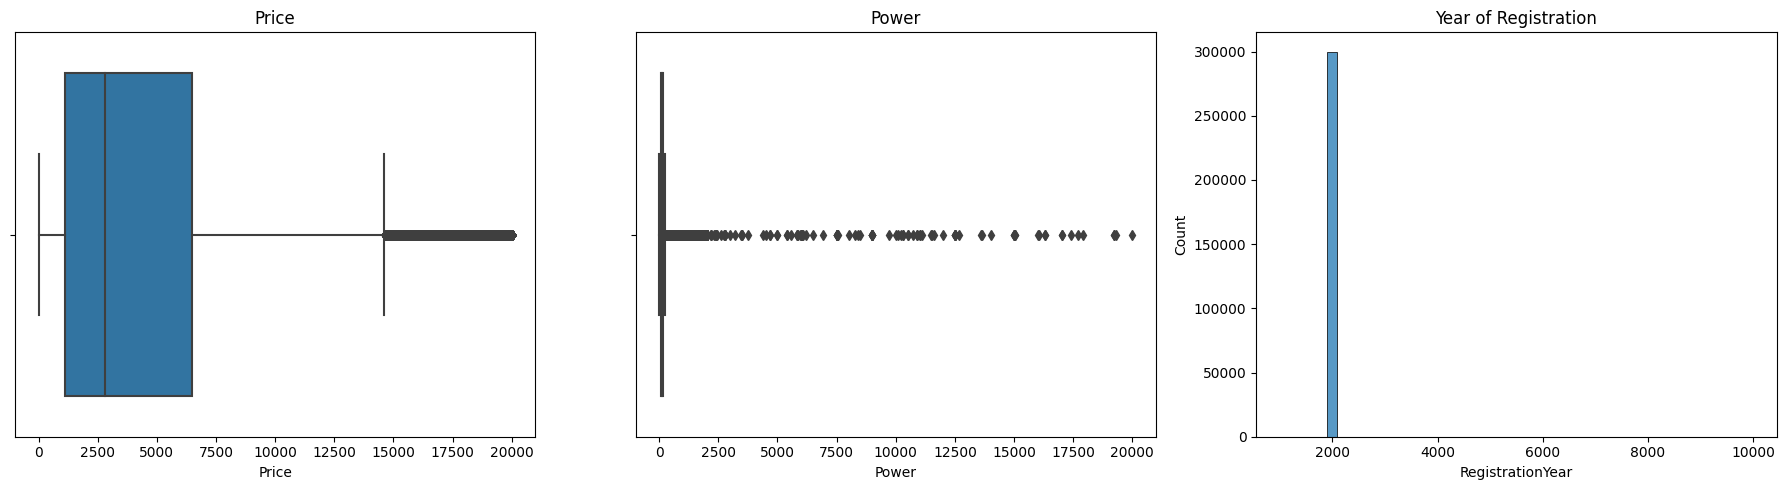

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df, x='Price', ax=axes[0])
axes[0].set_title('Price')

sns.boxplot(data=df, x='Power', ax=axes[1])
axes[1].set_title('Power')

sns.histplot(data=df, x='RegistrationYear', bins=50, ax=axes[2])
axes[2].set_title('Year of Registration')

plt.tight_layout()
plt.show() 

These are the three features that - based on the values from '.describe()' - are suspected as having outliers. According to these plots, there are many problems in regards to the integrity of the values present. The RegistrationYear is not indicating a mass amount of errors. However, due to the fact that the years are separated in increments of 2,000, it can be difficult to visualize the borders. The Power feature is showing values over 500 ps, which is simply not realistic for a majority of consumer vehicles. The Price feature is showing some values near 0-1 which is likely inaccurate data. There is also a high amount of extreme outliers in regards to high prices. 

In [14]:
# filtering out outliers 

# no cars worth zero or excessive amounts
df = df[(df['Price'] > 100) & (df['Price'] < 150000)]

# most cars are under 500 PS
df = df[(df['Power'] > 10) & (df['Power'] < 500)]

# reasonable registration years
df = df[(df['RegistrationYear'] >= 1990) & (df['RegistrationYear'] <= 2023)] 

In [15]:
df.describe()

,Price,RegistrationYear,Power,Mileage
count,251044.000000,251044.000000,251044.000000,251044.000000
mean,4946.451674,2004.046215,121.830229,127414.417393
std,4643.151876,6.081826,53.446860,37147.871188
min,101.000000,1990.000000,11.000000,5000.000000
25%,1400.000000,2000.000000,80.000000,125000.000000
50%,3299.000000,2004.000000,115.000000,150000.000000
75%,7000.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,490.000000,150000.000000


In [16]:
df.duplicated().sum()

0

Data is cleaned and ready for processing.

## Model training

In [17]:
# define target and features 
X = df.drop(columns='Price')
y = df['Price'] 

Using ordinal encoding since even though it is not the most optimal, it allows the full dataset to be used; maintaining as much data integrity as possible.

In [19]:
# splitting the data - 60train/20valid/20test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [21]:
# getting all categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns

encoders = {}
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
X_test_encoded = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    
    def safe_transform(values, encoder):
        most_frequent = encoder.classes_[0]  
        return [val if val in encoder.classes_ else most_frequent for val in values]
    
    X_valid_encoded[col] = le.transform(safe_transform(X_valid[col].astype(str), le))
    X_test_encoded[col] = le.transform(safe_transform(X_test[col].astype(str), le)) 

Although this is the first model being trained, we can tell without any other comparison that its RMSE is extremely high and just not suitable in any way for actual data from Rusty Bargain. Let's try another.

In [24]:
# decision tree model 
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train_encoded, y_train)
preds_dt = dt.predict(X_valid_encoded)
rmse_dt = mean_squared_error(y_valid, preds_dt, squared=False)
"Decision Tree RMSE:", rmse_dt

('Decision Tree RMSE:', 2032.687133029411)

This RMSE is not too bad, being the first model being trained, I wonder if the others below will outperform this one. 

In [25]:
# random forest model 
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_encoded, y_train)
preds_rf = rf.predict(X_valid_encoded)
rmse_rf = mean_squared_error(y_valid, preds_rf, squared=False)
"Random Forest RMSE:", rmse_rf

('Random Forest RMSE:', 1953.7471864554054)

This is our model with the best accuracy so far, relatively close to the Decision Tree score but still with good improvement. Let's see if gradient boosting makes any difference.

In [26]:
lgb_train = lgb.Dataset(X_train_encoded, label=y_train)
lgb_valid = lgb.Dataset(X_valid_encoded, label=y_valid, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 7,
    'verbose': -1
} 

In [27]:
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], early_stopping_rounds=20)
preds_lgb = lgb_model.predict(X_valid_encoded)
rmse_lgb = mean_squared_error(y_valid, preds_lgb, squared=False)
"LightGBM RMSE:", rmse_lgb

/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 4318.97
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 4024.93
[3]	valid_0's rmse: 3767.46
[4]	valid_0's rmse: 3541.75
[5]	valid_0's rmse: 3341.37
[6]	valid_0's rmse: 3167.26
[7]	valid_0's rmse: 3017.33
[8]	valid_0's rmse: 2884.22
[9]	valid_0's rmse: 2765.36
[10]	valid_0's rmse: 2662.76
[11]	valid_0's rmse: 2574.41
[12]	valid_0's rmse: 2499.03
[13]	valid_0's rmse: 2434.7
[14]	valid_0's rmse: 2375.97
[15]	valid_0's rmse: 2327.05
[16]	valid_0's rmse: 2283.02
[17]	valid_0's rmse: 2243.75
[18]	valid_0's rmse: 2211.69
[19]	valid_0's rmse: 2182.58
[20]	valid_0's rmse: 2155.37
[21]	valid_0's rmse: 2131.32
[22]	valid_0's rmse: 2111.51
[23]	valid_0's rmse: 2094.19
[24]	valid_0's rmse: 2075.64
[25]	valid_0's rmse: 2060.53
[26]	valid_0's rmse: 2047.07
[27]	valid_0's rmse: 2032.53
[28]	valid_0's rmse: 2023.02
[29]	valid_0's rmse: 2011.63
[30]	valid_0's rmse: 2002.23
[31]	valid_0's rmse: 1992.51
[32]	valid_0's rmse: 1985.57
[33]	valid_0's rmse: 

('LightGBM RMSE:', 1808.6622263697784)

The above model is producing the best RMSE score out of all the present models. It's no surprise that the gradient boosting did in fact minimize loss and produce the best model so far. Now, I will proceed with further analyzing the quality and speed of the models. 

## Model analysis

Analyzing the speed of the models. 

In [28]:
# decision tree speed 
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
start = time.time()
dt.fit(X_train_encoded, y_train)
end = time.time()
print("Decision Tree Training Time:", end - start, "seconds")

# prediction time 
start = time.time()
_ = dt.predict(X_valid_encoded)
end = time.time()
print("Decision Tree Prediction Time:", end - start, "seconds")

Decision Tree Training Time: 0.22264885902404785 seconds
Decision Tree Prediction Time: 0.005517005920410156 seconds


In [29]:
# random forest speed
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
start = time.time()
rf.fit(X_train_encoded, y_train)
end = time.time()
print("Random Forest Training Time:", end - start, "seconds") 

# prediction time 
start = time.time()
_ = rf.predict(X_valid_encoded)
end = time.time()
print("Random Forest Prediction Time:", end - start, "seconds") 

Random Forest Training Time: 6.581711530685425 seconds
Random Forest Prediction Time: 0.21787667274475098 seconds


In [30]:
# LightGBM speed 
lgb_train = lgb.Dataset(X_train_encoded, label=y_train, categorical_feature='auto')
lgb_valid = lgb.Dataset(X_valid_encoded, label=y_valid, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 7,
    'verbose': -1
} 


start = time.time()
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], early_stopping_rounds=20)
end = time.time()
print("LightGBM Training Time:", end - start, "seconds")

# prediction time
start = time.time()
_ = lgb_model.predict(X_valid_encoded)
end = time.time()
print("LightGBM Prediction Time:", end - start, "seconds")

/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 4318.97
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 4024.93
[3]	valid_0's rmse: 3767.46
[4]	valid_0's rmse: 3541.75
[5]	valid_0's rmse: 3341.37
[6]	valid_0's rmse: 3167.26
[7]	valid_0's rmse: 3017.33
[8]	valid_0's rmse: 2884.22
[9]	valid_0's rmse: 2765.36
[10]	valid_0's rmse: 2662.76
[11]	valid_0's rmse: 2574.41
[12]	valid_0's rmse: 2499.03
[13]	valid_0's rmse: 2434.7
[14]	valid_0's rmse: 2375.97
[15]	valid_0's rmse: 2327.05
[16]	valid_0's rmse: 2283.02
[17]	valid_0's rmse: 2243.75
[18]	valid_0's rmse: 2211.69
[19]	valid_0's rmse: 2182.58
[20]	valid_0's rmse: 2155.37
[21]	valid_0's rmse: 2131.32
[22]	valid_0's rmse: 2111.51
[23]	valid_0's rmse: 2094.19
[24]	valid_0's rmse: 2075.64
[25]	valid_0's rmse: 2060.53
[26]	valid_0's rmse: 2047.07
[27]	valid_0's rmse: 2032.53
[28]	valid_0's rmse: 2023.02
[29]	valid_0's rmse: 2011.63
[30]	valid_0's rmse: 2002.23
[31]	valid_0's rmse: 1992.51
[32]	valid_0's rmse: 1985.57
[33]	valid_0's rmse: 

Here, we can see that the fastest model is by far the Decision Tree model. Both the training and prediction speed far surpassed the speed of the other two models. Contrary to the other quality metrics, the Random Forest came in second with some decent times, and the LightGBM model came in last with the slowest processing speeds. Now it it just a question of what is more important: speed or quality?

In [31]:
# finding the MAE of the three models 
mae_dt = mean_absolute_error(y_valid, preds_dt)
mae_rf = mean_absolute_error(y_valid, preds_rf)
mae_lgb = mean_absolute_error(y_valid, preds_lgb) 

In [32]:
print("Decision Tree MAE:", mae_dt)
print("Random Forest MAE:", mae_rf)
print("LightGBM MAE:", mae_lgb) 

Decision Tree MAE: 1347.835673349695
Random Forest MAE: 1304.934247899388
LightGBM MAE: 1191.7389202626237


Considering the goal of these models, this algorithm will be used time and time again by multiple users at once. The performance of this algorithm needs to be at its most convenient if it is to attract and retain customers as the client is hoping for. With that in mind, speed may be prioritized over a lower quality. The Decision Tree is the fastest by far, and thankfully, the quality metrics tell us that the performance is not too bad and can be improved. Therefore, we will move on with our final testing on the Decision Tree model. 

# Final Testing

In [33]:
# final testing with decision tree model 
dt_preds_test = dt.predict(X_test_encoded)

In [34]:
# evaluation metrics 
rmse_test = mean_squared_error(y_test, dt_preds_test, squared=False)
mae_test = mean_absolute_error(y_test, dt_preds_test)

In [35]:
print("Decision Tree Test RMSE:", rmse_test)
print("Decision Tree Test MAE:", mae_test) 

Decision Tree Test RMSE: 2028.1376885431157
Decision Tree Test MAE: 1343.3256596048807


In [36]:
# prediction time of test set 
start = time.time()
_ = dt.predict(X_test_encoded)
end = time.time()

"Decision Tree Test Prediction Time:", end - start, "seconds"

('Decision Tree Test Prediction Time:', 0.005396842956542969, 'seconds')

The metrics and evaluation speeds from this final testing with the Decision Tree tell us that the model does well with with new data and does a good job of making fast and rasonably accurate predictions. Although there were models that were slightly more accurate, this model does a good job of balancing that interpretability of predictions and speed. This is what makes it a great choice for Rusty Bargain.

As expected, the LightGBM model has the lowest MAE score, suggesting the best predictive quality of the three models. With the rest of the scores being consistent with the previous findings, we have security in the choice of moving forward with the LightGBM model.

# Final Conclusion

Tasked with helping Rusty Bargain develop an app that will assist customers in finding the market value of their car, the primary focus of this project was model training and performance. Upon loading the data, there was little to no alterations that needed to be conducted. Some features were removed, as they were unimportant in determining the price through our machine learning models. With that, it was also found that there were a great many outliers in a small handful of features, which were quickly fixed so as not to skew the data while being trained. Finally, aside from some missing values and some duplicates that were easily handled, the data was ready for training and analysis. Moving onto the main portion of this project, I moved forward with training three models - Random Forest, Decision Tree, and LightGBM. When comparing the three models, I used the RMSE and MAE quality metrics, while also testing the training speed (in seconds) as well as the prediction speed. For RMSE, the LightGBM model performed the best, closely followed by the Random Forest model. In regards to the MAE, the trend was the same. The LightGBM model was performing the best, followed by the Random Forest model. But looking at the processing speed of the various models, it was found that the Decision Tree had performed the fastest, very obvioulsy outperforming the other two models in this aspect. The LightGBM model, which was the front runner until this point, came in last with a comparatively slow processing speeds. Seeing as though this algorithm will be used by customers on a constant basis, speed is a major component when choosing which model to move forward with. So I proceeded to use the DecisionTree model for final testing. Here it wwas found that the model has a good balance of quality and speed, which can be improved in the future. Based on this information as a whole, I can only suggest that Rusty Bargain take use of the DecisionTree model as it is the most rounded in terms of quality and speed. This will be the most effective in assisting them with their app which will undoubtedly attract new customers and retain current ones. 